In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision.models import AlexNet_Weights
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.447), (0.247, 0.243, 0.262))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
AlexNet = models.alexnet(weights=AlexNet_Weights.DEFAULT)
AlexNet.classifier[6] = nn.Linear(4096, 10)
AlexNet.to(device)
print(AlexNet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# optimizer
optimizer = optim.SGD(AlexNet.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [6]:
#transformations for metamorphic testing
transformations = [
    transforms.RandomRotation(degrees=10),  # Small rotation
    transforms.ColorJitter(brightness=0.2),  # Slight brightness change
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))  # Small translation
]

In [7]:
# Validation Function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_running_loss += loss.item()
            _, preds = torch.max(output.data, 1)
            val_running_correct += (preds == target).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    val_loss = val_running_loss / len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct / len(test_dataloader.dataset)
    
    # Calculate metrics
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    return val_loss, val_accuracy, precision, recall, f1

In [8]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for  data, target in tqdm(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [9]:
reject_diffs = []

# If batch_size > 1, we get multiple images each iteration.
for i, (image, label) in enumerate(tqdm(testloader)):
   
    image = image.to(device)


    with torch.no_grad():
        original_output = AlexNet(image)
        original_prob = F.softmax(original_output, dim=1)
        original_confidence, original_pred = torch.max(original_prob, dim=1)  # shape [batch_size]

    
    for tf in transformations:
        transformed_image = tf(image.cpu()).to(device)
        
        with torch.no_grad():
            transformed_output = AlexNet(transformed_image)
            transformed_prob = F.softmax(transformed_output, dim=1)
            transformed_confidence, transformed_pred = torch.max(transformed_prob, dim=1)
        
        # Compute absolute difference in confidence for the entire batch
        # shape [batch_size]
        diff_tensor = torch.abs(original_confidence - transformed_confidence)

        
        diff_mean = diff_tensor.mean().item()
        reject_diffs.append(diff_mean)

        
        print(f"Batch {i} | "
              f"Reject Differential (mean over batch): {diff_mean:.4f}")

  1%|▍                                                            | 2/313 [00:00<01:29,  3.47it/s]

Batch 0 | Reject Differential (mean over batch): 0.0362
Batch 0 | Reject Differential (mean over batch): 0.0637
Batch 0 | Reject Differential (mean over batch): 0.0422
Batch 1 | Reject Differential (mean over batch): 0.0363
Batch 1 | Reject Differential (mean over batch): 0.0486
Batch 1 | Reject Differential (mean over batch): 0.0410


  1%|▌                                                            | 3/313 [00:00<01:13,  4.21it/s]

Batch 2 | Reject Differential (mean over batch): 0.0511
Batch 2 | Reject Differential (mean over batch): 0.0554
Batch 2 | Reject Differential (mean over batch): 0.0576
Batch 3 | Reject Differential (mean over batch): 0.0699


  2%|▉                                                            | 5/313 [00:01<00:57,  5.32it/s]

Batch 3 | Reject Differential (mean over batch): 0.0714
Batch 3 | Reject Differential (mean over batch): 0.0658
Batch 4 | Reject Differential (mean over batch): 0.0457
Batch 4 | Reject Differential (mean over batch): 0.0633
Batch 4 | Reject Differential (mean over batch): 0.0466


  2%|█▎                                                           | 7/313 [00:01<00:50,  6.06it/s]

Batch 5 | Reject Differential (mean over batch): 0.0600
Batch 5 | Reject Differential (mean over batch): 0.0602
Batch 5 | Reject Differential (mean over batch): 0.0581
Batch 6 | Reject Differential (mean over batch): 0.0591
Batch 6 | Reject Differential (mean over batch): 0.0560
Batch 6 | Reject Differential (mean over batch): 0.0471


  3%|█▊                                                           | 9/313 [00:01<00:45,  6.74it/s]

Batch 7 | Reject Differential (mean over batch): 0.0536
Batch 7 | Reject Differential (mean over batch): 0.0600
Batch 7 | Reject Differential (mean over batch): 0.0386
Batch 8 | Reject Differential (mean over batch): 0.0697
Batch 8 | Reject Differential (mean over batch): 0.0824
Batch 8 | Reject Differential (mean over batch): 0.0605


  4%|██                                                          | 11/313 [00:01<00:42,  7.15it/s]

Batch 9 | Reject Differential (mean over batch): 0.0534
Batch 9 | Reject Differential (mean over batch): 0.0671
Batch 9 | Reject Differential (mean over batch): 0.0562
Batch 10 | Reject Differential (mean over batch): 0.0372
Batch 10 | Reject Differential (mean over batch): 0.0559
Batch 10 | Reject Differential (mean over batch): 0.0417


  4%|██▍                                                         | 13/313 [00:02<00:39,  7.60it/s]

Batch 11 | Reject Differential (mean over batch): 0.0521
Batch 11 | Reject Differential (mean over batch): 0.0693
Batch 11 | Reject Differential (mean over batch): 0.0486
Batch 12 | Reject Differential (mean over batch): 0.0599
Batch 12 | Reject Differential (mean over batch): 0.0636
Batch 12 | Reject Differential (mean over batch): 0.0453


  5%|██▉                                                         | 15/313 [00:02<00:37,  8.03it/s]

Batch 13 | Reject Differential (mean over batch): 0.0579
Batch 13 | Reject Differential (mean over batch): 0.0720
Batch 13 | Reject Differential (mean over batch): 0.0552
Batch 14 | Reject Differential (mean over batch): 0.0654
Batch 14 | Reject Differential (mean over batch): 0.0754
Batch 14 | Reject Differential (mean over batch): 0.0421


  5%|███▎                                                        | 17/313 [00:02<00:36,  8.06it/s]

Batch 15 | Reject Differential (mean over batch): 0.0641
Batch 15 | Reject Differential (mean over batch): 0.0710
Batch 15 | Reject Differential (mean over batch): 0.0488
Batch 16 | Reject Differential (mean over batch): 0.0487
Batch 16 | Reject Differential (mean over batch): 0.0699
Batch 16 | Reject Differential (mean over batch): 0.0570


  6%|███▋                                                        | 19/313 [00:02<00:35,  8.27it/s]

Batch 17 | Reject Differential (mean over batch): 0.0638
Batch 17 | Reject Differential (mean over batch): 0.0593
Batch 17 | Reject Differential (mean over batch): 0.0444
Batch 18 | Reject Differential (mean over batch): 0.0578
Batch 18 | Reject Differential (mean over batch): 0.0511
Batch 18 | Reject Differential (mean over batch): 0.0434


  7%|████                                                        | 21/313 [00:03<00:35,  8.23it/s]

Batch 19 | Reject Differential (mean over batch): 0.0529
Batch 19 | Reject Differential (mean over batch): 0.0755
Batch 19 | Reject Differential (mean over batch): 0.0529
Batch 20 | Reject Differential (mean over batch): 0.0625
Batch 20 | Reject Differential (mean over batch): 0.0630
Batch 20 | Reject Differential (mean over batch): 0.0536


  7%|████▍                                                       | 23/313 [00:03<00:34,  8.44it/s]

Batch 21 | Reject Differential (mean over batch): 0.0367
Batch 21 | Reject Differential (mean over batch): 0.0472
Batch 21 | Reject Differential (mean over batch): 0.0425
Batch 22 | Reject Differential (mean over batch): 0.0490
Batch 22 | Reject Differential (mean over batch): 0.0680
Batch 22 | Reject Differential (mean over batch): 0.0535


  8%|████▊                                                       | 25/313 [00:03<00:33,  8.50it/s]

Batch 23 | Reject Differential (mean over batch): 0.0953
Batch 23 | Reject Differential (mean over batch): 0.0882
Batch 23 | Reject Differential (mean over batch): 0.0719
Batch 24 | Reject Differential (mean over batch): 0.0577
Batch 24 | Reject Differential (mean over batch): 0.0769
Batch 24 | Reject Differential (mean over batch): 0.0506


  9%|█████▏                                                      | 27/313 [00:03<00:33,  8.52it/s]

Batch 25 | Reject Differential (mean over batch): 0.0441
Batch 25 | Reject Differential (mean over batch): 0.0503
Batch 25 | Reject Differential (mean over batch): 0.0448
Batch 26 | Reject Differential (mean over batch): 0.0627
Batch 26 | Reject Differential (mean over batch): 0.0550
Batch 26 | Reject Differential (mean over batch): 0.0445


  9%|█████▌                                                      | 29/313 [00:04<00:34,  8.25it/s]

Batch 27 | Reject Differential (mean over batch): 0.0378
Batch 27 | Reject Differential (mean over batch): 0.0531
Batch 27 | Reject Differential (mean over batch): 0.0334
Batch 28 | Reject Differential (mean over batch): 0.0457
Batch 28 | Reject Differential (mean over batch): 0.0484
Batch 28 | Reject Differential (mean over batch): 0.0480


 10%|█████▉                                                      | 31/313 [00:04<00:33,  8.36it/s]

Batch 29 | Reject Differential (mean over batch): 0.0626
Batch 29 | Reject Differential (mean over batch): 0.0560
Batch 29 | Reject Differential (mean over batch): 0.0461
Batch 30 | Reject Differential (mean over batch): 0.0485
Batch 30 | Reject Differential (mean over batch): 0.0556
Batch 30 | Reject Differential (mean over batch): 0.0525


 11%|██████▎                                                     | 33/313 [00:04<00:33,  8.48it/s]

Batch 31 | Reject Differential (mean over batch): 0.0538
Batch 31 | Reject Differential (mean over batch): 0.0639
Batch 31 | Reject Differential (mean over batch): 0.0520
Batch 32 | Reject Differential (mean over batch): 0.0590
Batch 32 | Reject Differential (mean over batch): 0.0746
Batch 32 | Reject Differential (mean over batch): 0.0578


 11%|██████▋                                                     | 35/313 [00:04<00:33,  8.37it/s]

Batch 33 | Reject Differential (mean over batch): 0.0629
Batch 33 | Reject Differential (mean over batch): 0.0665
Batch 33 | Reject Differential (mean over batch): 0.0427
Batch 34 | Reject Differential (mean over batch): 0.0796
Batch 34 | Reject Differential (mean over batch): 0.0944
Batch 34 | Reject Differential (mean over batch): 0.0553


 12%|███████                                                     | 37/313 [00:05<00:33,  8.30it/s]

Batch 35 | Reject Differential (mean over batch): 0.0638
Batch 35 | Reject Differential (mean over batch): 0.0740
Batch 35 | Reject Differential (mean over batch): 0.0582
Batch 36 | Reject Differential (mean over batch): 0.0678
Batch 36 | Reject Differential (mean over batch): 0.0683
Batch 36 | Reject Differential (mean over batch): 0.0696


 12%|███████▍                                                    | 39/313 [00:05<00:32,  8.35it/s]

Batch 37 | Reject Differential (mean over batch): 0.0773
Batch 37 | Reject Differential (mean over batch): 0.0777
Batch 37 | Reject Differential (mean over batch): 0.0548
Batch 38 | Reject Differential (mean over batch): 0.0567
Batch 38 | Reject Differential (mean over batch): 0.0495
Batch 38 | Reject Differential (mean over batch): 0.0428


 13%|███████▊                                                    | 41/313 [00:05<00:32,  8.27it/s]

Batch 39 | Reject Differential (mean over batch): 0.0591
Batch 39 | Reject Differential (mean over batch): 0.0674
Batch 39 | Reject Differential (mean over batch): 0.0478
Batch 40 | Reject Differential (mean over batch): 0.0434
Batch 40 | Reject Differential (mean over batch): 0.0544
Batch 40 | Reject Differential (mean over batch): 0.0399


 14%|████████▏                                                   | 43/313 [00:05<00:32,  8.37it/s]

Batch 41 | Reject Differential (mean over batch): 0.0558
Batch 41 | Reject Differential (mean over batch): 0.0627
Batch 41 | Reject Differential (mean over batch): 0.0516
Batch 42 | Reject Differential (mean over batch): 0.0757
Batch 42 | Reject Differential (mean over batch): 0.0753
Batch 42 | Reject Differential (mean over batch): 0.0530


 14%|████████▋                                                   | 45/313 [00:06<00:34,  7.73it/s]

Batch 43 | Reject Differential (mean over batch): 0.0584
Batch 43 | Reject Differential (mean over batch): 0.0672
Batch 43 | Reject Differential (mean over batch): 0.0602
Batch 44 | Reject Differential (mean over batch): 0.0588
Batch 44 | Reject Differential (mean over batch): 0.0513
Batch 44 | Reject Differential (mean over batch): 0.0465


 15%|█████████                                                   | 47/313 [00:06<00:34,  7.68it/s]

Batch 45 | Reject Differential (mean over batch): 0.0509
Batch 45 | Reject Differential (mean over batch): 0.0495
Batch 45 | Reject Differential (mean over batch): 0.0364
Batch 46 | Reject Differential (mean over batch): 0.0522
Batch 46 | Reject Differential (mean over batch): 0.0732
Batch 46 | Reject Differential (mean over batch): 0.0409


 16%|█████████▍                                                  | 49/313 [00:06<00:34,  7.76it/s]

Batch 47 | Reject Differential (mean over batch): 0.0499
Batch 47 | Reject Differential (mean over batch): 0.0600
Batch 47 | Reject Differential (mean over batch): 0.0603
Batch 48 | Reject Differential (mean over batch): 0.0512
Batch 48 | Reject Differential (mean over batch): 0.0651
Batch 48 | Reject Differential (mean over batch): 0.0550


 16%|█████████▊                                                  | 51/313 [00:06<00:32,  8.14it/s]

Batch 49 | Reject Differential (mean over batch): 0.0508
Batch 49 | Reject Differential (mean over batch): 0.0563
Batch 49 | Reject Differential (mean over batch): 0.0530
Batch 50 | Reject Differential (mean over batch): 0.0806
Batch 50 | Reject Differential (mean over batch): 0.0853
Batch 50 | Reject Differential (mean over batch): 0.0526


 17%|██████████▏                                                 | 53/313 [00:07<00:30,  8.39it/s]

Batch 51 | Reject Differential (mean over batch): 0.0465
Batch 51 | Reject Differential (mean over batch): 0.0624
Batch 51 | Reject Differential (mean over batch): 0.0452
Batch 52 | Reject Differential (mean over batch): 0.0646
Batch 52 | Reject Differential (mean over batch): 0.0688
Batch 52 | Reject Differential (mean over batch): 0.0455


 18%|██████████▌                                                 | 55/313 [00:07<00:30,  8.40it/s]

Batch 53 | Reject Differential (mean over batch): 0.0496
Batch 53 | Reject Differential (mean over batch): 0.0863
Batch 53 | Reject Differential (mean over batch): 0.0777
Batch 54 | Reject Differential (mean over batch): 0.0572
Batch 54 | Reject Differential (mean over batch): 0.0668
Batch 54 | Reject Differential (mean over batch): 0.0527


 18%|██████████▉                                                 | 57/313 [00:07<00:29,  8.74it/s]

Batch 55 | Reject Differential (mean over batch): 0.0449
Batch 55 | Reject Differential (mean over batch): 0.0529
Batch 55 | Reject Differential (mean over batch): 0.0452
Batch 56 | Reject Differential (mean over batch): 0.0623
Batch 56 | Reject Differential (mean over batch): 0.0539
Batch 56 | Reject Differential (mean over batch): 0.0497


 19%|███████████▎                                                | 59/313 [00:07<00:28,  8.94it/s]

Batch 57 | Reject Differential (mean over batch): 0.0387
Batch 57 | Reject Differential (mean over batch): 0.0569
Batch 57 | Reject Differential (mean over batch): 0.0494
Batch 58 | Reject Differential (mean over batch): 0.0394
Batch 58 | Reject Differential (mean over batch): 0.0486
Batch 58 | Reject Differential (mean over batch): 0.0392


 19%|███████████▋                                                | 61/313 [00:07<00:28,  8.88it/s]

Batch 59 | Reject Differential (mean over batch): 0.0451
Batch 59 | Reject Differential (mean over batch): 0.0841
Batch 59 | Reject Differential (mean over batch): 0.0632
Batch 60 | Reject Differential (mean over batch): 0.0380
Batch 60 | Reject Differential (mean over batch): 0.0435
Batch 60 | Reject Differential (mean over batch): 0.0298


 20%|████████████                                                | 63/313 [00:08<00:27,  9.11it/s]

Batch 61 | Reject Differential (mean over batch): 0.0666
Batch 61 | Reject Differential (mean over batch): 0.0847
Batch 61 | Reject Differential (mean over batch): 0.0493
Batch 62 | Reject Differential (mean over batch): 0.0398
Batch 62 | Reject Differential (mean over batch): 0.0475
Batch 62 | Reject Differential (mean over batch): 0.0425


 21%|████████████▍                                               | 65/313 [00:08<00:27,  9.01it/s]

Batch 63 | Reject Differential (mean over batch): 0.0570
Batch 63 | Reject Differential (mean over batch): 0.0879
Batch 63 | Reject Differential (mean over batch): 0.0470
Batch 64 | Reject Differential (mean over batch): 0.0421
Batch 64 | Reject Differential (mean over batch): 0.0367
Batch 64 | Reject Differential (mean over batch): 0.0325


 21%|████████████▊                                               | 67/313 [00:08<00:26,  9.15it/s]

Batch 65 | Reject Differential (mean over batch): 0.0451
Batch 65 | Reject Differential (mean over batch): 0.0649
Batch 65 | Reject Differential (mean over batch): 0.0478
Batch 66 | Reject Differential (mean over batch): 0.0474
Batch 66 | Reject Differential (mean over batch): 0.0714
Batch 66 | Reject Differential (mean over batch): 0.0584


 22%|█████████████▏                                              | 69/313 [00:08<00:26,  9.24it/s]

Batch 67 | Reject Differential (mean over batch): 0.0558
Batch 67 | Reject Differential (mean over batch): 0.0713
Batch 67 | Reject Differential (mean over batch): 0.0504
Batch 68 | Reject Differential (mean over batch): 0.0529
Batch 68 | Reject Differential (mean over batch): 0.1139
Batch 68 | Reject Differential (mean over batch): 0.0806


 23%|█████████████▌                                              | 71/313 [00:09<00:28,  8.64it/s]

Batch 69 | Reject Differential (mean over batch): 0.0557
Batch 69 | Reject Differential (mean over batch): 0.0575
Batch 69 | Reject Differential (mean over batch): 0.0476
Batch 70 | Reject Differential (mean over batch): 0.0571
Batch 70 | Reject Differential (mean over batch): 0.0658
Batch 70 | Reject Differential (mean over batch): 0.0548


 23%|█████████████▉                                              | 73/313 [00:09<00:26,  8.97it/s]

Batch 71 | Reject Differential (mean over batch): 0.0578
Batch 71 | Reject Differential (mean over batch): 0.0620
Batch 71 | Reject Differential (mean over batch): 0.0405
Batch 72 | Reject Differential (mean over batch): 0.0463
Batch 72 | Reject Differential (mean over batch): 0.0563
Batch 72 | Reject Differential (mean over batch): 0.0403


 24%|██████████████▍                                             | 75/313 [00:09<00:25,  9.16it/s]

Batch 73 | Reject Differential (mean over batch): 0.0559
Batch 73 | Reject Differential (mean over batch): 0.0791
Batch 73 | Reject Differential (mean over batch): 0.0544
Batch 74 | Reject Differential (mean over batch): 0.0590
Batch 74 | Reject Differential (mean over batch): 0.0796
Batch 74 | Reject Differential (mean over batch): 0.0458


 25%|██████████████▊                                             | 77/313 [00:09<00:25,  9.22it/s]

Batch 75 | Reject Differential (mean over batch): 0.0534
Batch 75 | Reject Differential (mean over batch): 0.0605
Batch 75 | Reject Differential (mean over batch): 0.0462
Batch 76 | Reject Differential (mean over batch): 0.0596
Batch 76 | Reject Differential (mean over batch): 0.0618
Batch 76 | Reject Differential (mean over batch): 0.0528


 25%|███████████████▏                                            | 79/313 [00:09<00:25,  9.34it/s]

Batch 77 | Reject Differential (mean over batch): 0.0560
Batch 77 | Reject Differential (mean over batch): 0.0666
Batch 77 | Reject Differential (mean over batch): 0.0428
Batch 78 | Reject Differential (mean over batch): 0.0554
Batch 78 | Reject Differential (mean over batch): 0.0658
Batch 78 | Reject Differential (mean over batch): 0.0416


 26%|███████████████▎                                            | 80/313 [00:10<00:26,  8.64it/s]

Batch 79 | Reject Differential (mean over batch): 0.0573
Batch 79 | Reject Differential (mean over batch): 0.0717
Batch 79 | Reject Differential (mean over batch): 0.0565
Batch 80 | Reject Differential (mean over batch): 0.0590
Batch 80 | Reject Differential (mean over batch): 0.0740


 26%|███████████████▋                                            | 82/313 [00:10<00:27,  8.45it/s]

Batch 80 | Reject Differential (mean over batch): 0.0542
Batch 81 | Reject Differential (mean over batch): 0.0455
Batch 81 | Reject Differential (mean over batch): 0.0597
Batch 81 | Reject Differential (mean over batch): 0.0540
Batch 82 | Reject Differential (mean over batch): 0.0417
Batch 82 | Reject Differential (mean over batch): 0.0441


 27%|████████████████                                            | 84/313 [00:10<00:25,  8.84it/s]

Batch 82 | Reject Differential (mean over batch): 0.0420
Batch 83 | Reject Differential (mean over batch): 0.0488
Batch 83 | Reject Differential (mean over batch): 0.0647
Batch 83 | Reject Differential (mean over batch): 0.0555
Batch 84 | Reject Differential (mean over batch): 0.0515
Batch 84 | Reject Differential (mean over batch): 0.0516


 27%|████████████████▍                                           | 86/313 [00:10<00:25,  9.04it/s]

Batch 84 | Reject Differential (mean over batch): 0.0449
Batch 85 | Reject Differential (mean over batch): 0.0806
Batch 85 | Reject Differential (mean over batch): 0.0710
Batch 85 | Reject Differential (mean over batch): 0.0492
Batch 86 | Reject Differential (mean over batch): 0.0778
Batch 86 | Reject Differential (mean over batch): 0.0832


 28%|████████████████▊                                           | 88/313 [00:10<00:24,  9.12it/s]

Batch 86 | Reject Differential (mean over batch): 0.0665
Batch 87 | Reject Differential (mean over batch): 0.0646
Batch 87 | Reject Differential (mean over batch): 0.0713
Batch 87 | Reject Differential (mean over batch): 0.0583
Batch 88 | Reject Differential (mean over batch): 0.0464
Batch 88 | Reject Differential (mean over batch): 0.0598


 29%|█████████████████▎                                          | 90/313 [00:11<00:24,  9.25it/s]

Batch 88 | Reject Differential (mean over batch): 0.0399
Batch 89 | Reject Differential (mean over batch): 0.0448
Batch 89 | Reject Differential (mean over batch): 0.0590
Batch 89 | Reject Differential (mean over batch): 0.0448
Batch 90 | Reject Differential (mean over batch): 0.0521
Batch 90 | Reject Differential (mean over batch): 0.0645


 29%|█████████████████▋                                          | 92/313 [00:11<00:23,  9.28it/s]

Batch 90 | Reject Differential (mean over batch): 0.0404
Batch 91 | Reject Differential (mean over batch): 0.0587
Batch 91 | Reject Differential (mean over batch): 0.0496
Batch 91 | Reject Differential (mean over batch): 0.0467
Batch 92 | Reject Differential (mean over batch): 0.0431
Batch 92 | Reject Differential (mean over batch): 0.0561


 30%|██████████████████                                          | 94/313 [00:11<00:23,  9.31it/s]

Batch 92 | Reject Differential (mean over batch): 0.0405
Batch 93 | Reject Differential (mean over batch): 0.0406
Batch 93 | Reject Differential (mean over batch): 0.0562
Batch 93 | Reject Differential (mean over batch): 0.0433
Batch 94 | Reject Differential (mean over batch): 0.0615
Batch 94 | Reject Differential (mean over batch): 0.0624


 31%|██████████████████▍                                         | 96/313 [00:11<00:23,  9.29it/s]

Batch 94 | Reject Differential (mean over batch): 0.0547
Batch 95 | Reject Differential (mean over batch): 0.0521
Batch 95 | Reject Differential (mean over batch): 0.0647
Batch 95 | Reject Differential (mean over batch): 0.0565
Batch 96 | Reject Differential (mean over batch): 0.0573
Batch 96 | Reject Differential (mean over batch): 0.0766


 31%|██████████████████▊                                         | 98/313 [00:12<00:22,  9.38it/s]

Batch 96 | Reject Differential (mean over batch): 0.0536
Batch 97 | Reject Differential (mean over batch): 0.0650
Batch 97 | Reject Differential (mean over batch): 0.0721
Batch 97 | Reject Differential (mean over batch): 0.0567
Batch 98 | Reject Differential (mean over batch): 0.0701
Batch 98 | Reject Differential (mean over batch): 0.0837


 32%|██████████████████▊                                        | 100/313 [00:12<00:22,  9.35it/s]

Batch 98 | Reject Differential (mean over batch): 0.0472
Batch 99 | Reject Differential (mean over batch): 0.0632
Batch 99 | Reject Differential (mean over batch): 0.0733
Batch 99 | Reject Differential (mean over batch): 0.0425
Batch 100 | Reject Differential (mean over batch): 0.0629
Batch 100 | Reject Differential (mean over batch): 0.0738


 33%|███████████████████▏                                       | 102/313 [00:12<00:22,  9.37it/s]

Batch 100 | Reject Differential (mean over batch): 0.0554
Batch 101 | Reject Differential (mean over batch): 0.0563
Batch 101 | Reject Differential (mean over batch): 0.0674
Batch 101 | Reject Differential (mean over batch): 0.0441
Batch 102 | Reject Differential (mean over batch): 0.0546


 33%|███████████████████▌                                       | 104/313 [00:12<00:22,  9.17it/s]

Batch 102 | Reject Differential (mean over batch): 0.0559
Batch 102 | Reject Differential (mean over batch): 0.0523
Batch 103 | Reject Differential (mean over batch): 0.0540
Batch 103 | Reject Differential (mean over batch): 0.0516
Batch 103 | Reject Differential (mean over batch): 0.0549
Batch 104 | Reject Differential (mean over batch): 0.0754


 34%|███████████████████▉                                       | 106/313 [00:12<00:22,  9.11it/s]

Batch 104 | Reject Differential (mean over batch): 0.0584
Batch 104 | Reject Differential (mean over batch): 0.0467
Batch 105 | Reject Differential (mean over batch): 0.0524
Batch 105 | Reject Differential (mean over batch): 0.0549
Batch 105 | Reject Differential (mean over batch): 0.0389
Batch 106 | Reject Differential (mean over batch): 0.0462


 35%|████████████████████▎                                      | 108/313 [00:13<00:22,  9.05it/s]

Batch 106 | Reject Differential (mean over batch): 0.0604
Batch 106 | Reject Differential (mean over batch): 0.0480
Batch 107 | Reject Differential (mean over batch): 0.0705
Batch 107 | Reject Differential (mean over batch): 0.0644
Batch 107 | Reject Differential (mean over batch): 0.0658
Batch 108 | Reject Differential (mean over batch): 0.0458


 35%|████████████████████▋                                      | 110/313 [00:13<00:23,  8.80it/s]

Batch 108 | Reject Differential (mean over batch): 0.0517
Batch 108 | Reject Differential (mean over batch): 0.0445
Batch 109 | Reject Differential (mean over batch): 0.0626
Batch 109 | Reject Differential (mean over batch): 0.0724
Batch 109 | Reject Differential (mean over batch): 0.0496


 36%|█████████████████████                                      | 112/313 [00:13<00:22,  9.04it/s]

Batch 110 | Reject Differential (mean over batch): 0.0477
Batch 110 | Reject Differential (mean over batch): 0.0561
Batch 110 | Reject Differential (mean over batch): 0.0549
Batch 111 | Reject Differential (mean over batch): 0.0553
Batch 111 | Reject Differential (mean over batch): 0.0795
Batch 111 | Reject Differential (mean over batch): 0.0505


 36%|█████████████████████▍                                     | 114/313 [00:13<00:21,  9.30it/s]

Batch 112 | Reject Differential (mean over batch): 0.0533
Batch 112 | Reject Differential (mean over batch): 0.0556
Batch 112 | Reject Differential (mean over batch): 0.0407
Batch 113 | Reject Differential (mean over batch): 0.0769
Batch 113 | Reject Differential (mean over batch): 0.0652
Batch 113 | Reject Differential (mean over batch): 0.0668


 37%|█████████████████████▊                                     | 116/313 [00:13<00:20,  9.50it/s]

Batch 114 | Reject Differential (mean over batch): 0.0583
Batch 114 | Reject Differential (mean over batch): 0.0823
Batch 114 | Reject Differential (mean over batch): 0.0570
Batch 115 | Reject Differential (mean over batch): 0.0405
Batch 115 | Reject Differential (mean over batch): 0.0768
Batch 115 | Reject Differential (mean over batch): 0.0461


 38%|██████████████████████▏                                    | 118/313 [00:14<00:20,  9.61it/s]

Batch 116 | Reject Differential (mean over batch): 0.0352
Batch 116 | Reject Differential (mean over batch): 0.0459
Batch 116 | Reject Differential (mean over batch): 0.0414
Batch 117 | Reject Differential (mean over batch): 0.0614
Batch 117 | Reject Differential (mean over batch): 0.0621
Batch 117 | Reject Differential (mean over batch): 0.0539


 38%|██████████████████████▌                                    | 120/313 [00:14<00:20,  9.41it/s]

Batch 118 | Reject Differential (mean over batch): 0.0578
Batch 118 | Reject Differential (mean over batch): 0.0483
Batch 118 | Reject Differential (mean over batch): 0.0402
Batch 119 | Reject Differential (mean over batch): 0.0476
Batch 119 | Reject Differential (mean over batch): 0.0571
Batch 119 | Reject Differential (mean over batch): 0.0550


 39%|██████████████████████▉                                    | 122/313 [00:14<00:20,  9.45it/s]

Batch 120 | Reject Differential (mean over batch): 0.0745
Batch 120 | Reject Differential (mean over batch): 0.0805
Batch 120 | Reject Differential (mean over batch): 0.0480
Batch 121 | Reject Differential (mean over batch): 0.0576
Batch 121 | Reject Differential (mean over batch): 0.0764
Batch 121 | Reject Differential (mean over batch): 0.0489


 40%|███████████████████████▎                                   | 124/313 [00:14<00:20,  9.27it/s]

Batch 122 | Reject Differential (mean over batch): 0.0611
Batch 122 | Reject Differential (mean over batch): 0.0613
Batch 122 | Reject Differential (mean over batch): 0.0442
Batch 123 | Reject Differential (mean over batch): 0.0673
Batch 123 | Reject Differential (mean over batch): 0.0648
Batch 123 | Reject Differential (mean over batch): 0.0520


 40%|███████████████████████▊                                   | 126/313 [00:15<00:19,  9.41it/s]

Batch 124 | Reject Differential (mean over batch): 0.0607
Batch 124 | Reject Differential (mean over batch): 0.0668
Batch 124 | Reject Differential (mean over batch): 0.0523
Batch 125 | Reject Differential (mean over batch): 0.0592
Batch 125 | Reject Differential (mean over batch): 0.0700
Batch 125 | Reject Differential (mean over batch): 0.0409


 41%|████████████████████████▏                                  | 128/313 [00:15<00:21,  8.54it/s]

Batch 126 | Reject Differential (mean over batch): 0.0517
Batch 126 | Reject Differential (mean over batch): 0.0535
Batch 126 | Reject Differential (mean over batch): 0.0487
Batch 127 | Reject Differential (mean over batch): 0.0364
Batch 127 | Reject Differential (mean over batch): 0.0569
Batch 127 | Reject Differential (mean over batch): 0.0403


 42%|████████████████████████▌                                  | 130/313 [00:15<00:21,  8.66it/s]

Batch 128 | Reject Differential (mean over batch): 0.0471
Batch 128 | Reject Differential (mean over batch): 0.0590
Batch 128 | Reject Differential (mean over batch): 0.0342
Batch 129 | Reject Differential (mean over batch): 0.0497
Batch 129 | Reject Differential (mean over batch): 0.0535
Batch 129 | Reject Differential (mean over batch): 0.0346


 42%|████████████████████████▉                                  | 132/313 [00:15<00:20,  8.99it/s]

Batch 130 | Reject Differential (mean over batch): 0.0491
Batch 130 | Reject Differential (mean over batch): 0.0507
Batch 130 | Reject Differential (mean over batch): 0.0351
Batch 131 | Reject Differential (mean over batch): 0.0595
Batch 131 | Reject Differential (mean over batch): 0.0539
Batch 131 | Reject Differential (mean over batch): 0.0511


 43%|█████████████████████████▎                                 | 134/313 [00:15<00:20,  8.68it/s]

Batch 132 | Reject Differential (mean over batch): 0.0596
Batch 132 | Reject Differential (mean over batch): 0.0698
Batch 132 | Reject Differential (mean over batch): 0.0534
Batch 133 | Reject Differential (mean over batch): 0.0490
Batch 133 | Reject Differential (mean over batch): 0.0586
Batch 133 | Reject Differential (mean over batch): 0.0444


 43%|█████████████████████████▋                                 | 136/313 [00:16<00:19,  9.01it/s]

Batch 134 | Reject Differential (mean over batch): 0.0748
Batch 134 | Reject Differential (mean over batch): 0.0666
Batch 134 | Reject Differential (mean over batch): 0.0551
Batch 135 | Reject Differential (mean over batch): 0.0529
Batch 135 | Reject Differential (mean over batch): 0.0517
Batch 135 | Reject Differential (mean over batch): 0.0397


 44%|██████████████████████████                                 | 138/313 [00:16<00:19,  9.10it/s]

Batch 136 | Reject Differential (mean over batch): 0.0576
Batch 136 | Reject Differential (mean over batch): 0.0687
Batch 136 | Reject Differential (mean over batch): 0.0558
Batch 137 | Reject Differential (mean over batch): 0.0368
Batch 137 | Reject Differential (mean over batch): 0.0592
Batch 137 | Reject Differential (mean over batch): 0.0555


 45%|██████████████████████████▍                                | 140/313 [00:16<00:18,  9.32it/s]

Batch 138 | Reject Differential (mean over batch): 0.0531
Batch 138 | Reject Differential (mean over batch): 0.0572
Batch 138 | Reject Differential (mean over batch): 0.0448
Batch 139 | Reject Differential (mean over batch): 0.0418
Batch 139 | Reject Differential (mean over batch): 0.0506
Batch 139 | Reject Differential (mean over batch): 0.0579


 45%|██████████████████████████▊                                | 142/313 [00:16<00:18,  9.43it/s]

Batch 140 | Reject Differential (mean over batch): 0.0495
Batch 140 | Reject Differential (mean over batch): 0.0687
Batch 140 | Reject Differential (mean over batch): 0.0485
Batch 141 | Reject Differential (mean over batch): 0.0547
Batch 141 | Reject Differential (mean over batch): 0.0719
Batch 141 | Reject Differential (mean over batch): 0.0539


 46%|███████████████████████████▏                               | 144/313 [00:17<00:18,  9.08it/s]

Batch 142 | Reject Differential (mean over batch): 0.0807
Batch 142 | Reject Differential (mean over batch): 0.0847
Batch 142 | Reject Differential (mean over batch): 0.0705
Batch 143 | Reject Differential (mean over batch): 0.0403
Batch 143 | Reject Differential (mean over batch): 0.0484
Batch 143 | Reject Differential (mean over batch): 0.0366


 47%|███████████████████████████▌                               | 146/313 [00:17<00:18,  9.25it/s]

Batch 144 | Reject Differential (mean over batch): 0.0415
Batch 144 | Reject Differential (mean over batch): 0.0589
Batch 144 | Reject Differential (mean over batch): 0.0570
Batch 145 | Reject Differential (mean over batch): 0.0492
Batch 145 | Reject Differential (mean over batch): 0.0514
Batch 145 | Reject Differential (mean over batch): 0.0532


 47%|███████████████████████████▉                               | 148/313 [00:17<00:18,  9.05it/s]

Batch 146 | Reject Differential (mean over batch): 0.0427
Batch 146 | Reject Differential (mean over batch): 0.0506
Batch 146 | Reject Differential (mean over batch): 0.0458
Batch 147 | Reject Differential (mean over batch): 0.0722
Batch 147 | Reject Differential (mean over batch): 0.1115
Batch 147 | Reject Differential (mean over batch): 0.0855


 48%|████████████████████████████▎                              | 150/313 [00:17<00:17,  9.22it/s]

Batch 148 | Reject Differential (mean over batch): 0.0771
Batch 148 | Reject Differential (mean over batch): 0.0781
Batch 148 | Reject Differential (mean over batch): 0.0508
Batch 149 | Reject Differential (mean over batch): 0.0741
Batch 149 | Reject Differential (mean over batch): 0.0812
Batch 149 | Reject Differential (mean over batch): 0.0689


 49%|████████████████████████████▋                              | 152/313 [00:17<00:17,  9.28it/s]

Batch 150 | Reject Differential (mean over batch): 0.0593
Batch 150 | Reject Differential (mean over batch): 0.0675
Batch 150 | Reject Differential (mean over batch): 0.0687
Batch 151 | Reject Differential (mean over batch): 0.0569
Batch 151 | Reject Differential (mean over batch): 0.0538
Batch 151 | Reject Differential (mean over batch): 0.0578


 49%|█████████████████████████████                              | 154/313 [00:18<00:17,  9.15it/s]

Batch 152 | Reject Differential (mean over batch): 0.0502
Batch 152 | Reject Differential (mean over batch): 0.0688
Batch 152 | Reject Differential (mean over batch): 0.0397
Batch 153 | Reject Differential (mean over batch): 0.0408
Batch 153 | Reject Differential (mean over batch): 0.0358
Batch 153 | Reject Differential (mean over batch): 0.0432


 50%|█████████████████████████████▍                             | 156/313 [00:18<00:18,  8.64it/s]

Batch 154 | Reject Differential (mean over batch): 0.0423
Batch 154 | Reject Differential (mean over batch): 0.0518
Batch 154 | Reject Differential (mean over batch): 0.0406
Batch 155 | Reject Differential (mean over batch): 0.0507
Batch 155 | Reject Differential (mean over batch): 0.0848
Batch 155 | Reject Differential (mean over batch): 0.0562


 50%|█████████████████████████████▊                             | 158/313 [00:18<00:17,  9.00it/s]

Batch 156 | Reject Differential (mean over batch): 0.0780
Batch 156 | Reject Differential (mean over batch): 0.0702
Batch 156 | Reject Differential (mean over batch): 0.0531
Batch 157 | Reject Differential (mean over batch): 0.0629
Batch 157 | Reject Differential (mean over batch): 0.0678
Batch 157 | Reject Differential (mean over batch): 0.0557


 51%|██████████████████████████████▏                            | 160/313 [00:18<00:18,  8.23it/s]

Batch 158 | Reject Differential (mean over batch): 0.0519
Batch 158 | Reject Differential (mean over batch): 0.0452
Batch 158 | Reject Differential (mean over batch): 0.0511
Batch 159 | Reject Differential (mean over batch): 0.0762
Batch 159 | Reject Differential (mean over batch): 0.0877
Batch 159 | Reject Differential (mean over batch): 0.0561


 52%|██████████████████████████████▌                            | 162/313 [00:19<00:17,  8.56it/s]

Batch 160 | Reject Differential (mean over batch): 0.0767
Batch 160 | Reject Differential (mean over batch): 0.0763
Batch 160 | Reject Differential (mean over batch): 0.0447
Batch 161 | Reject Differential (mean over batch): 0.0619
Batch 161 | Reject Differential (mean over batch): 0.0541
Batch 161 | Reject Differential (mean over batch): 0.0531


 52%|██████████████████████████████▉                            | 164/313 [00:19<00:17,  8.73it/s]

Batch 162 | Reject Differential (mean over batch): 0.0735
Batch 162 | Reject Differential (mean over batch): 0.0783
Batch 162 | Reject Differential (mean over batch): 0.0657
Batch 163 | Reject Differential (mean over batch): 0.0704
Batch 163 | Reject Differential (mean over batch): 0.0856
Batch 163 | Reject Differential (mean over batch): 0.0717


 53%|███████████████████████████████▎                           | 166/313 [00:19<00:16,  8.81it/s]

Batch 164 | Reject Differential (mean over batch): 0.0661
Batch 164 | Reject Differential (mean over batch): 0.0630
Batch 164 | Reject Differential (mean over batch): 0.0581
Batch 165 | Reject Differential (mean over batch): 0.0504
Batch 165 | Reject Differential (mean over batch): 0.0741
Batch 165 | Reject Differential (mean over batch): 0.0497


 54%|███████████████████████████████▋                           | 168/313 [00:19<00:15,  9.10it/s]

Batch 166 | Reject Differential (mean over batch): 0.0485
Batch 166 | Reject Differential (mean over batch): 0.0582
Batch 166 | Reject Differential (mean over batch): 0.0478
Batch 167 | Reject Differential (mean over batch): 0.0876
Batch 167 | Reject Differential (mean over batch): 0.0753
Batch 167 | Reject Differential (mean over batch): 0.0743


 54%|████████████████████████████████                           | 170/313 [00:19<00:15,  9.19it/s]

Batch 168 | Reject Differential (mean over batch): 0.0674
Batch 168 | Reject Differential (mean over batch): 0.0624
Batch 168 | Reject Differential (mean over batch): 0.0552
Batch 169 | Reject Differential (mean over batch): 0.0601
Batch 169 | Reject Differential (mean over batch): 0.0687
Batch 169 | Reject Differential (mean over batch): 0.0569


 55%|████████████████████████████████▍                          | 172/313 [00:20<00:15,  9.20it/s]

Batch 170 | Reject Differential (mean over batch): 0.0485
Batch 170 | Reject Differential (mean over batch): 0.0725
Batch 170 | Reject Differential (mean over batch): 0.0610
Batch 171 | Reject Differential (mean over batch): 0.0687
Batch 171 | Reject Differential (mean over batch): 0.0734
Batch 171 | Reject Differential (mean over batch): 0.0414


 56%|████████████████████████████████▊                          | 174/313 [00:20<00:14,  9.36it/s]

Batch 172 | Reject Differential (mean over batch): 0.0450
Batch 172 | Reject Differential (mean over batch): 0.0549
Batch 172 | Reject Differential (mean over batch): 0.0490
Batch 173 | Reject Differential (mean over batch): 0.0450
Batch 173 | Reject Differential (mean over batch): 0.0423
Batch 173 | Reject Differential (mean over batch): 0.0395


 56%|█████████████████████████████████▏                         | 176/313 [00:20<00:14,  9.50it/s]

Batch 174 | Reject Differential (mean over batch): 0.0473
Batch 174 | Reject Differential (mean over batch): 0.0602
Batch 174 | Reject Differential (mean over batch): 0.0537
Batch 175 | Reject Differential (mean over batch): 0.0556
Batch 175 | Reject Differential (mean over batch): 0.0624
Batch 175 | Reject Differential (mean over batch): 0.0537


 57%|█████████████████████████████████▌                         | 178/313 [00:20<00:14,  9.57it/s]

Batch 176 | Reject Differential (mean over batch): 0.0686
Batch 176 | Reject Differential (mean over batch): 0.0696
Batch 176 | Reject Differential (mean over batch): 0.0438
Batch 177 | Reject Differential (mean over batch): 0.0512
Batch 177 | Reject Differential (mean over batch): 0.0561
Batch 177 | Reject Differential (mean over batch): 0.0453


 58%|█████████████████████████████████▉                         | 180/313 [00:21<00:13,  9.56it/s]

Batch 178 | Reject Differential (mean over batch): 0.0562
Batch 178 | Reject Differential (mean over batch): 0.0611
Batch 178 | Reject Differential (mean over batch): 0.0630
Batch 179 | Reject Differential (mean over batch): 0.0737
Batch 179 | Reject Differential (mean over batch): 0.0716
Batch 179 | Reject Differential (mean over batch): 0.0443


 58%|██████████████████████████████████▎                        | 182/313 [00:21<00:13,  9.63it/s]

Batch 180 | Reject Differential (mean over batch): 0.0778
Batch 180 | Reject Differential (mean over batch): 0.0768
Batch 180 | Reject Differential (mean over batch): 0.0570
Batch 181 | Reject Differential (mean over batch): 0.0672
Batch 181 | Reject Differential (mean over batch): 0.0670
Batch 181 | Reject Differential (mean over batch): 0.0551


 59%|██████████████████████████████████▋                        | 184/313 [00:21<00:13,  9.63it/s]

Batch 182 | Reject Differential (mean over batch): 0.0506
Batch 182 | Reject Differential (mean over batch): 0.0527
Batch 182 | Reject Differential (mean over batch): 0.0380
Batch 183 | Reject Differential (mean over batch): 0.0468
Batch 183 | Reject Differential (mean over batch): 0.0524
Batch 183 | Reject Differential (mean over batch): 0.0328


 59%|███████████████████████████████████                        | 186/313 [00:21<00:13,  9.56it/s]

Batch 184 | Reject Differential (mean over batch): 0.0790
Batch 184 | Reject Differential (mean over batch): 0.0810
Batch 184 | Reject Differential (mean over batch): 0.0682
Batch 185 | Reject Differential (mean over batch): 0.0530
Batch 185 | Reject Differential (mean over batch): 0.0582
Batch 185 | Reject Differential (mean over batch): 0.0486


 60%|███████████████████████████████████▍                       | 188/313 [00:21<00:13,  9.56it/s]

Batch 186 | Reject Differential (mean over batch): 0.0531
Batch 186 | Reject Differential (mean over batch): 0.0630
Batch 186 | Reject Differential (mean over batch): 0.0541
Batch 187 | Reject Differential (mean over batch): 0.0784
Batch 187 | Reject Differential (mean over batch): 0.0739
Batch 187 | Reject Differential (mean over batch): 0.0507


 61%|███████████████████████████████████▊                       | 190/313 [00:22<00:13,  9.31it/s]

Batch 188 | Reject Differential (mean over batch): 0.0669
Batch 188 | Reject Differential (mean over batch): 0.0631
Batch 188 | Reject Differential (mean over batch): 0.0575
Batch 189 | Reject Differential (mean over batch): 0.0809
Batch 189 | Reject Differential (mean over batch): 0.0760
Batch 189 | Reject Differential (mean over batch): 0.0634


 61%|████████████████████████████████████▏                      | 192/313 [00:22<00:13,  8.78it/s]

Batch 190 | Reject Differential (mean over batch): 0.0429
Batch 190 | Reject Differential (mean over batch): 0.0551
Batch 190 | Reject Differential (mean over batch): 0.0414
Batch 191 | Reject Differential (mean over batch): 0.0807
Batch 191 | Reject Differential (mean over batch): 0.0729
Batch 191 | Reject Differential (mean over batch): 0.0528


 62%|████████████████████████████████████▌                      | 194/313 [00:22<00:14,  8.49it/s]

Batch 192 | Reject Differential (mean over batch): 0.0571
Batch 192 | Reject Differential (mean over batch): 0.0571
Batch 192 | Reject Differential (mean over batch): 0.0459
Batch 193 | Reject Differential (mean over batch): 0.0727
Batch 193 | Reject Differential (mean over batch): 0.0705
Batch 193 | Reject Differential (mean over batch): 0.0592


 63%|████████████████████████████████████▉                      | 196/313 [00:22<00:13,  8.73it/s]

Batch 194 | Reject Differential (mean over batch): 0.0453
Batch 194 | Reject Differential (mean over batch): 0.0418
Batch 194 | Reject Differential (mean over batch): 0.0449
Batch 195 | Reject Differential (mean over batch): 0.0411
Batch 195 | Reject Differential (mean over batch): 0.0591
Batch 195 | Reject Differential (mean over batch): 0.0431


 63%|█████████████████████████████████████▎                     | 198/313 [00:22<00:12,  9.08it/s]

Batch 196 | Reject Differential (mean over batch): 0.0465
Batch 196 | Reject Differential (mean over batch): 0.0762
Batch 196 | Reject Differential (mean over batch): 0.0533
Batch 197 | Reject Differential (mean over batch): 0.0444
Batch 197 | Reject Differential (mean over batch): 0.0449
Batch 197 | Reject Differential (mean over batch): 0.0440


 64%|█████████████████████████████████████▋                     | 200/313 [00:23<00:12,  9.09it/s]

Batch 198 | Reject Differential (mean over batch): 0.0566
Batch 198 | Reject Differential (mean over batch): 0.0481
Batch 198 | Reject Differential (mean over batch): 0.0414
Batch 199 | Reject Differential (mean over batch): 0.0662
Batch 199 | Reject Differential (mean over batch): 0.0824
Batch 199 | Reject Differential (mean over batch): 0.0680


 65%|██████████████████████████████████████                     | 202/313 [00:23<00:12,  8.65it/s]

Batch 200 | Reject Differential (mean over batch): 0.0601
Batch 200 | Reject Differential (mean over batch): 0.0510
Batch 200 | Reject Differential (mean over batch): 0.0559
Batch 201 | Reject Differential (mean over batch): 0.0386
Batch 201 | Reject Differential (mean over batch): 0.0452
Batch 201 | Reject Differential (mean over batch): 0.0342


 65%|██████████████████████████████████████▍                    | 204/313 [00:23<00:12,  8.44it/s]

Batch 202 | Reject Differential (mean over batch): 0.0497
Batch 202 | Reject Differential (mean over batch): 0.0556
Batch 202 | Reject Differential (mean over batch): 0.0370
Batch 203 | Reject Differential (mean over batch): 0.0506
Batch 203 | Reject Differential (mean over batch): 0.0716
Batch 203 | Reject Differential (mean over batch): 0.0433


 66%|██████████████████████████████████████▊                    | 206/313 [00:23<00:12,  8.83it/s]

Batch 204 | Reject Differential (mean over batch): 0.0595
Batch 204 | Reject Differential (mean over batch): 0.0637
Batch 204 | Reject Differential (mean over batch): 0.0616
Batch 205 | Reject Differential (mean over batch): 0.0481
Batch 205 | Reject Differential (mean over batch): 0.0634
Batch 205 | Reject Differential (mean over batch): 0.0504


 66%|███████████████████████████████████████▏                   | 208/313 [00:24<00:11,  9.21it/s]

Batch 206 | Reject Differential (mean over batch): 0.0703
Batch 206 | Reject Differential (mean over batch): 0.0806
Batch 206 | Reject Differential (mean over batch): 0.0593
Batch 207 | Reject Differential (mean over batch): 0.0811
Batch 207 | Reject Differential (mean over batch): 0.0739
Batch 207 | Reject Differential (mean over batch): 0.0490


 67%|███████████████████████████████████████▌                   | 210/313 [00:24<00:11,  9.18it/s]

Batch 208 | Reject Differential (mean over batch): 0.0375
Batch 208 | Reject Differential (mean over batch): 0.0519
Batch 208 | Reject Differential (mean over batch): 0.0426
Batch 209 | Reject Differential (mean over batch): 0.0706
Batch 209 | Reject Differential (mean over batch): 0.0632
Batch 209 | Reject Differential (mean over batch): 0.0518


 68%|███████████████████████████████████████▉                   | 212/313 [00:24<00:11,  8.89it/s]

Batch 210 | Reject Differential (mean over batch): 0.0497
Batch 210 | Reject Differential (mean over batch): 0.0551
Batch 210 | Reject Differential (mean over batch): 0.0488
Batch 211 | Reject Differential (mean over batch): 0.0418
Batch 211 | Reject Differential (mean over batch): 0.0454
Batch 211 | Reject Differential (mean over batch): 0.0429


 68%|████████████████████████████████████████▎                  | 214/313 [00:24<00:11,  8.61it/s]

Batch 212 | Reject Differential (mean over batch): 0.0558
Batch 212 | Reject Differential (mean over batch): 0.0684
Batch 212 | Reject Differential (mean over batch): 0.0476
Batch 213 | Reject Differential (mean over batch): 0.0721
Batch 213 | Reject Differential (mean over batch): 0.0772
Batch 213 | Reject Differential (mean over batch): 0.0590


 69%|████████████████████████████████████████▋                  | 216/313 [00:24<00:10,  8.96it/s]

Batch 214 | Reject Differential (mean over batch): 0.0359
Batch 214 | Reject Differential (mean over batch): 0.0430
Batch 214 | Reject Differential (mean over batch): 0.0346
Batch 215 | Reject Differential (mean over batch): 0.0488
Batch 215 | Reject Differential (mean over batch): 0.0691
Batch 215 | Reject Differential (mean over batch): 0.0549


 70%|█████████████████████████████████████████                  | 218/313 [00:25<00:10,  9.12it/s]

Batch 216 | Reject Differential (mean over batch): 0.0469
Batch 216 | Reject Differential (mean over batch): 0.0576
Batch 216 | Reject Differential (mean over batch): 0.0481
Batch 217 | Reject Differential (mean over batch): 0.0551
Batch 217 | Reject Differential (mean over batch): 0.0681
Batch 217 | Reject Differential (mean over batch): 0.0509


 70%|█████████████████████████████████████████▍                 | 220/313 [00:25<00:10,  9.10it/s]

Batch 218 | Reject Differential (mean over batch): 0.0748
Batch 218 | Reject Differential (mean over batch): 0.0789
Batch 218 | Reject Differential (mean over batch): 0.0372
Batch 219 | Reject Differential (mean over batch): 0.0581
Batch 219 | Reject Differential (mean over batch): 0.0778
Batch 219 | Reject Differential (mean over batch): 0.0522


 71%|█████████████████████████████████████████▊                 | 222/313 [00:25<00:10,  9.05it/s]

Batch 220 | Reject Differential (mean over batch): 0.0553
Batch 220 | Reject Differential (mean over batch): 0.0609
Batch 220 | Reject Differential (mean over batch): 0.0505
Batch 221 | Reject Differential (mean over batch): 0.0634
Batch 221 | Reject Differential (mean over batch): 0.0601
Batch 221 | Reject Differential (mean over batch): 0.0438


 72%|██████████████████████████████████████████▏                | 224/313 [00:25<00:09,  9.22it/s]

Batch 222 | Reject Differential (mean over batch): 0.0490
Batch 222 | Reject Differential (mean over batch): 0.0521
Batch 222 | Reject Differential (mean over batch): 0.0501
Batch 223 | Reject Differential (mean over batch): 0.0569
Batch 223 | Reject Differential (mean over batch): 0.0729
Batch 223 | Reject Differential (mean over batch): 0.0517


 72%|██████████████████████████████████████████▌                | 226/313 [00:26<00:09,  9.40it/s]

Batch 224 | Reject Differential (mean over batch): 0.0552
Batch 224 | Reject Differential (mean over batch): 0.0636
Batch 224 | Reject Differential (mean over batch): 0.0475
Batch 225 | Reject Differential (mean over batch): 0.0551
Batch 225 | Reject Differential (mean over batch): 0.0673
Batch 225 | Reject Differential (mean over batch): 0.0439


 73%|██████████████████████████████████████████▉                | 228/313 [00:26<00:09,  8.97it/s]

Batch 226 | Reject Differential (mean over batch): 0.0653
Batch 226 | Reject Differential (mean over batch): 0.0579
Batch 226 | Reject Differential (mean over batch): 0.0464
Batch 227 | Reject Differential (mean over batch): 0.0779
Batch 227 | Reject Differential (mean over batch): 0.0791
Batch 227 | Reject Differential (mean over batch): 0.0686


 73%|███████████████████████████████████████████▎               | 230/313 [00:26<00:08,  9.27it/s]

Batch 228 | Reject Differential (mean over batch): 0.0535
Batch 228 | Reject Differential (mean over batch): 0.0622
Batch 228 | Reject Differential (mean over batch): 0.0503
Batch 229 | Reject Differential (mean over batch): 0.0506
Batch 229 | Reject Differential (mean over batch): 0.0499
Batch 229 | Reject Differential (mean over batch): 0.0468


 74%|███████████████████████████████████████████▋               | 232/313 [00:26<00:08,  9.48it/s]

Batch 230 | Reject Differential (mean over batch): 0.0569
Batch 230 | Reject Differential (mean over batch): 0.0674
Batch 230 | Reject Differential (mean over batch): 0.0484
Batch 231 | Reject Differential (mean over batch): 0.0499
Batch 231 | Reject Differential (mean over batch): 0.0669
Batch 231 | Reject Differential (mean over batch): 0.0501


 75%|████████████████████████████████████████████               | 234/313 [00:26<00:08,  9.41it/s]

Batch 232 | Reject Differential (mean over batch): 0.0710
Batch 232 | Reject Differential (mean over batch): 0.0850
Batch 232 | Reject Differential (mean over batch): 0.0636
Batch 233 | Reject Differential (mean over batch): 0.0413
Batch 233 | Reject Differential (mean over batch): 0.0488
Batch 233 | Reject Differential (mean over batch): 0.0414


 75%|████████████████████████████████████████████▍              | 236/313 [00:27<00:08,  9.57it/s]

Batch 234 | Reject Differential (mean over batch): 0.0716
Batch 234 | Reject Differential (mean over batch): 0.0761
Batch 234 | Reject Differential (mean over batch): 0.0538
Batch 235 | Reject Differential (mean over batch): 0.0625
Batch 235 | Reject Differential (mean over batch): 0.0658
Batch 235 | Reject Differential (mean over batch): 0.0486


 76%|████████████████████████████████████████████▊              | 238/313 [00:27<00:07,  9.43it/s]

Batch 236 | Reject Differential (mean over batch): 0.0453
Batch 236 | Reject Differential (mean over batch): 0.0757
Batch 236 | Reject Differential (mean over batch): 0.0572
Batch 237 | Reject Differential (mean over batch): 0.0767
Batch 237 | Reject Differential (mean over batch): 0.0859
Batch 237 | Reject Differential (mean over batch): 0.0566


 77%|█████████████████████████████████████████████▏             | 240/313 [00:27<00:07,  9.38it/s]

Batch 238 | Reject Differential (mean over batch): 0.0832
Batch 238 | Reject Differential (mean over batch): 0.0689
Batch 238 | Reject Differential (mean over batch): 0.0613
Batch 239 | Reject Differential (mean over batch): 0.0513
Batch 239 | Reject Differential (mean over batch): 0.0406
Batch 239 | Reject Differential (mean over batch): 0.0398


 77%|█████████████████████████████████████████████▌             | 242/313 [00:27<00:08,  8.65it/s]

Batch 240 | Reject Differential (mean over batch): 0.0670
Batch 240 | Reject Differential (mean over batch): 0.0563
Batch 240 | Reject Differential (mean over batch): 0.0425
Batch 241 | Reject Differential (mean over batch): 0.0471
Batch 241 | Reject Differential (mean over batch): 0.0527
Batch 241 | Reject Differential (mean over batch): 0.0435


 78%|█████████████████████████████████████████████▉             | 244/313 [00:28<00:07,  9.05it/s]

Batch 242 | Reject Differential (mean over batch): 0.0805
Batch 242 | Reject Differential (mean over batch): 0.0827
Batch 242 | Reject Differential (mean over batch): 0.0542
Batch 243 | Reject Differential (mean over batch): 0.0561
Batch 243 | Reject Differential (mean over batch): 0.0585
Batch 243 | Reject Differential (mean over batch): 0.0441


 79%|██████████████████████████████████████████████▎            | 246/313 [00:28<00:07,  8.43it/s]

Batch 244 | Reject Differential (mean over batch): 0.0675
Batch 244 | Reject Differential (mean over batch): 0.0754
Batch 244 | Reject Differential (mean over batch): 0.0456
Batch 245 | Reject Differential (mean over batch): 0.0545
Batch 245 | Reject Differential (mean over batch): 0.0777
Batch 245 | Reject Differential (mean over batch): 0.0798


 79%|██████████████████████████████████████████████▋            | 248/313 [00:28<00:07,  8.39it/s]

Batch 246 | Reject Differential (mean over batch): 0.0501
Batch 246 | Reject Differential (mean over batch): 0.0455
Batch 246 | Reject Differential (mean over batch): 0.0407
Batch 247 | Reject Differential (mean over batch): 0.0551
Batch 247 | Reject Differential (mean over batch): 0.0546
Batch 247 | Reject Differential (mean over batch): 0.0372


 80%|███████████████████████████████████████████████            | 250/313 [00:28<00:07,  8.67it/s]

Batch 248 | Reject Differential (mean over batch): 0.0593
Batch 248 | Reject Differential (mean over batch): 0.0623
Batch 248 | Reject Differential (mean over batch): 0.0435
Batch 249 | Reject Differential (mean over batch): 0.0631
Batch 249 | Reject Differential (mean over batch): 0.0490
Batch 249 | Reject Differential (mean over batch): 0.0492


 81%|███████████████████████████████████████████████▌           | 252/313 [00:28<00:06,  8.92it/s]

Batch 250 | Reject Differential (mean over batch): 0.0528
Batch 250 | Reject Differential (mean over batch): 0.0464
Batch 250 | Reject Differential (mean over batch): 0.0572
Batch 251 | Reject Differential (mean over batch): 0.0560
Batch 251 | Reject Differential (mean over batch): 0.0767
Batch 251 | Reject Differential (mean over batch): 0.0621


 81%|███████████████████████████████████████████████▉           | 254/313 [00:29<00:06,  8.79it/s]

Batch 252 | Reject Differential (mean over batch): 0.0439
Batch 252 | Reject Differential (mean over batch): 0.0638
Batch 252 | Reject Differential (mean over batch): 0.0401
Batch 253 | Reject Differential (mean over batch): 0.0686
Batch 253 | Reject Differential (mean over batch): 0.0638
Batch 253 | Reject Differential (mean over batch): 0.0593


 82%|████████████████████████████████████████████████▎          | 256/313 [00:29<00:06,  9.10it/s]

Batch 254 | Reject Differential (mean over batch): 0.0609
Batch 254 | Reject Differential (mean over batch): 0.0483
Batch 254 | Reject Differential (mean over batch): 0.0438
Batch 255 | Reject Differential (mean over batch): 0.0580
Batch 255 | Reject Differential (mean over batch): 0.0546
Batch 255 | Reject Differential (mean over batch): 0.0468


 82%|████████████████████████████████████████████████▋          | 258/313 [00:29<00:05,  9.28it/s]

Batch 256 | Reject Differential (mean over batch): 0.0523
Batch 256 | Reject Differential (mean over batch): 0.0498
Batch 256 | Reject Differential (mean over batch): 0.0466
Batch 257 | Reject Differential (mean over batch): 0.0489
Batch 257 | Reject Differential (mean over batch): 0.0569
Batch 257 | Reject Differential (mean over batch): 0.0377


 83%|█████████████████████████████████████████████████          | 260/313 [00:29<00:05,  9.00it/s]

Batch 258 | Reject Differential (mean over batch): 0.0689
Batch 258 | Reject Differential (mean over batch): 0.0634
Batch 258 | Reject Differential (mean over batch): 0.0542
Batch 259 | Reject Differential (mean over batch): 0.0546
Batch 259 | Reject Differential (mean over batch): 0.0528
Batch 259 | Reject Differential (mean over batch): 0.0442


 84%|█████████████████████████████████████████████████▍         | 262/313 [00:30<00:05,  9.20it/s]

Batch 260 | Reject Differential (mean over batch): 0.0651
Batch 260 | Reject Differential (mean over batch): 0.0702
Batch 260 | Reject Differential (mean over batch): 0.0488
Batch 261 | Reject Differential (mean over batch): 0.0512
Batch 261 | Reject Differential (mean over batch): 0.0508
Batch 261 | Reject Differential (mean over batch): 0.0489


 84%|█████████████████████████████████████████████████▊         | 264/313 [00:30<00:05,  8.88it/s]

Batch 262 | Reject Differential (mean over batch): 0.0523
Batch 262 | Reject Differential (mean over batch): 0.0603
Batch 262 | Reject Differential (mean over batch): 0.0442
Batch 263 | Reject Differential (mean over batch): 0.0377
Batch 263 | Reject Differential (mean over batch): 0.0512
Batch 263 | Reject Differential (mean over batch): 0.0463


 85%|██████████████████████████████████████████████████▏        | 266/313 [00:30<00:05,  8.91it/s]

Batch 264 | Reject Differential (mean over batch): 0.0564
Batch 264 | Reject Differential (mean over batch): 0.0629
Batch 264 | Reject Differential (mean over batch): 0.0497
Batch 265 | Reject Differential (mean over batch): 0.0641
Batch 265 | Reject Differential (mean over batch): 0.0703
Batch 265 | Reject Differential (mean over batch): 0.0526


 86%|██████████████████████████████████████████████████▌        | 268/313 [00:30<00:04,  9.20it/s]

Batch 266 | Reject Differential (mean over batch): 0.0540
Batch 266 | Reject Differential (mean over batch): 0.0546
Batch 266 | Reject Differential (mean over batch): 0.0545
Batch 267 | Reject Differential (mean over batch): 0.0551
Batch 267 | Reject Differential (mean over batch): 0.0591
Batch 267 | Reject Differential (mean over batch): 0.0436


 86%|██████████████████████████████████████████████████▉        | 270/313 [00:30<00:04,  9.41it/s]

Batch 268 | Reject Differential (mean over batch): 0.0602
Batch 268 | Reject Differential (mean over batch): 0.0596
Batch 268 | Reject Differential (mean over batch): 0.0443
Batch 269 | Reject Differential (mean over batch): 0.0760
Batch 269 | Reject Differential (mean over batch): 0.0835
Batch 269 | Reject Differential (mean over batch): 0.0635


 87%|███████████████████████████████████████████████████▎       | 272/313 [00:31<00:04,  9.51it/s]

Batch 270 | Reject Differential (mean over batch): 0.0387
Batch 270 | Reject Differential (mean over batch): 0.0632
Batch 270 | Reject Differential (mean over batch): 0.0448
Batch 271 | Reject Differential (mean over batch): 0.0935
Batch 271 | Reject Differential (mean over batch): 0.0912
Batch 271 | Reject Differential (mean over batch): 0.0746


 88%|███████████████████████████████████████████████████▋       | 274/313 [00:31<00:04,  9.42it/s]

Batch 272 | Reject Differential (mean over batch): 0.0709
Batch 272 | Reject Differential (mean over batch): 0.0744
Batch 272 | Reject Differential (mean over batch): 0.0620
Batch 273 | Reject Differential (mean over batch): 0.0683
Batch 273 | Reject Differential (mean over batch): 0.0733
Batch 273 | Reject Differential (mean over batch): 0.0507


 88%|████████████████████████████████████████████████████       | 276/313 [00:31<00:04,  8.87it/s]

Batch 274 | Reject Differential (mean over batch): 0.0642
Batch 274 | Reject Differential (mean over batch): 0.0530
Batch 274 | Reject Differential (mean over batch): 0.0397
Batch 275 | Reject Differential (mean over batch): 0.0552
Batch 275 | Reject Differential (mean over batch): 0.0689
Batch 275 | Reject Differential (mean over batch): 0.0492


 89%|████████████████████████████████████████████████████▍      | 278/313 [00:31<00:03,  9.24it/s]

Batch 276 | Reject Differential (mean over batch): 0.0511
Batch 276 | Reject Differential (mean over batch): 0.0596
Batch 276 | Reject Differential (mean over batch): 0.0554
Batch 277 | Reject Differential (mean over batch): 0.0699
Batch 277 | Reject Differential (mean over batch): 0.0810
Batch 277 | Reject Differential (mean over batch): 0.0554


 89%|████████████████████████████████████████████████████▊      | 280/313 [00:32<00:03,  9.21it/s]

Batch 278 | Reject Differential (mean over batch): 0.0372
Batch 278 | Reject Differential (mean over batch): 0.0503
Batch 278 | Reject Differential (mean over batch): 0.0528
Batch 279 | Reject Differential (mean over batch): 0.0565
Batch 279 | Reject Differential (mean over batch): 0.0659
Batch 279 | Reject Differential (mean over batch): 0.0592


 90%|█████████████████████████████████████████████████████▏     | 282/313 [00:32<00:03,  9.22it/s]

Batch 280 | Reject Differential (mean over batch): 0.0528
Batch 280 | Reject Differential (mean over batch): 0.0540
Batch 280 | Reject Differential (mean over batch): 0.0550
Batch 281 | Reject Differential (mean over batch): 0.0825
Batch 281 | Reject Differential (mean over batch): 0.0944
Batch 281 | Reject Differential (mean over batch): 0.0625


 91%|█████████████████████████████████████████████████████▌     | 284/313 [00:32<00:03,  9.38it/s]

Batch 282 | Reject Differential (mean over batch): 0.0630
Batch 282 | Reject Differential (mean over batch): 0.0655
Batch 282 | Reject Differential (mean over batch): 0.0687
Batch 283 | Reject Differential (mean over batch): 0.0403
Batch 283 | Reject Differential (mean over batch): 0.0478
Batch 283 | Reject Differential (mean over batch): 0.0366


 91%|█████████████████████████████████████████████████████▉     | 286/313 [00:32<00:02,  9.21it/s]

Batch 284 | Reject Differential (mean over batch): 0.0564
Batch 284 | Reject Differential (mean over batch): 0.0663
Batch 284 | Reject Differential (mean over batch): 0.0651
Batch 285 | Reject Differential (mean over batch): 0.0723
Batch 285 | Reject Differential (mean over batch): 0.0784
Batch 285 | Reject Differential (mean over batch): 0.0585


 92%|██████████████████████████████████████████████████████▎    | 288/313 [00:32<00:02,  9.42it/s]

Batch 286 | Reject Differential (mean over batch): 0.0432
Batch 286 | Reject Differential (mean over batch): 0.0512
Batch 286 | Reject Differential (mean over batch): 0.0465
Batch 287 | Reject Differential (mean over batch): 0.0527
Batch 287 | Reject Differential (mean over batch): 0.0529
Batch 287 | Reject Differential (mean over batch): 0.0490


 93%|██████████████████████████████████████████████████████▋    | 290/313 [00:33<00:02,  9.57it/s]

Batch 288 | Reject Differential (mean over batch): 0.0600
Batch 288 | Reject Differential (mean over batch): 0.0621
Batch 288 | Reject Differential (mean over batch): 0.0482
Batch 289 | Reject Differential (mean over batch): 0.0812
Batch 289 | Reject Differential (mean over batch): 0.0826
Batch 289 | Reject Differential (mean over batch): 0.0683


 93%|███████████████████████████████████████████████████████    | 292/313 [00:33<00:02,  9.65it/s]

Batch 290 | Reject Differential (mean over batch): 0.0653
Batch 290 | Reject Differential (mean over batch): 0.0796
Batch 290 | Reject Differential (mean over batch): 0.0634
Batch 291 | Reject Differential (mean over batch): 0.0704
Batch 291 | Reject Differential (mean over batch): 0.0651
Batch 291 | Reject Differential (mean over batch): 0.0504


 94%|███████████████████████████████████████████████████████▍   | 294/313 [00:33<00:02,  9.47it/s]

Batch 292 | Reject Differential (mean over batch): 0.0509
Batch 292 | Reject Differential (mean over batch): 0.0560
Batch 292 | Reject Differential (mean over batch): 0.0472
Batch 293 | Reject Differential (mean over batch): 0.0462
Batch 293 | Reject Differential (mean over batch): 0.0779
Batch 293 | Reject Differential (mean over batch): 0.0583


 95%|███████████████████████████████████████████████████████▊   | 296/313 [00:33<00:01,  9.47it/s]

Batch 294 | Reject Differential (mean over batch): 0.0448
Batch 294 | Reject Differential (mean over batch): 0.0666
Batch 294 | Reject Differential (mean over batch): 0.0476
Batch 295 | Reject Differential (mean over batch): 0.0606
Batch 295 | Reject Differential (mean over batch): 0.0566
Batch 295 | Reject Differential (mean over batch): 0.0529


 95%|████████████████████████████████████████████████████████▏  | 298/313 [00:33<00:01,  9.42it/s]

Batch 296 | Reject Differential (mean over batch): 0.0476
Batch 296 | Reject Differential (mean over batch): 0.0532
Batch 296 | Reject Differential (mean over batch): 0.0374
Batch 297 | Reject Differential (mean over batch): 0.0617
Batch 297 | Reject Differential (mean over batch): 0.0668
Batch 297 | Reject Differential (mean over batch): 0.0499


 96%|████████████████████████████████████████████████████████▌  | 300/313 [00:34<00:01,  9.42it/s]

Batch 298 | Reject Differential (mean over batch): 0.0671
Batch 298 | Reject Differential (mean over batch): 0.0667
Batch 298 | Reject Differential (mean over batch): 0.0495
Batch 299 | Reject Differential (mean over batch): 0.0474
Batch 299 | Reject Differential (mean over batch): 0.0692
Batch 299 | Reject Differential (mean over batch): 0.0565


 96%|████████████████████████████████████████████████████████▉  | 302/313 [00:34<00:01,  9.53it/s]

Batch 300 | Reject Differential (mean over batch): 0.0500
Batch 300 | Reject Differential (mean over batch): 0.0468
Batch 300 | Reject Differential (mean over batch): 0.0466
Batch 301 | Reject Differential (mean over batch): 0.0778
Batch 301 | Reject Differential (mean over batch): 0.0756
Batch 301 | Reject Differential (mean over batch): 0.0596


 97%|█████████████████████████████████████████████████████████▎ | 304/313 [00:34<00:00,  9.24it/s]

Batch 302 | Reject Differential (mean over batch): 0.0662
Batch 302 | Reject Differential (mean over batch): 0.0692
Batch 302 | Reject Differential (mean over batch): 0.0533
Batch 303 | Reject Differential (mean over batch): 0.0587
Batch 303 | Reject Differential (mean over batch): 0.0575
Batch 303 | Reject Differential (mean over batch): 0.0546


 98%|█████████████████████████████████████████████████████████▋ | 306/313 [00:34<00:00,  9.44it/s]

Batch 304 | Reject Differential (mean over batch): 0.0479
Batch 304 | Reject Differential (mean over batch): 0.0592
Batch 304 | Reject Differential (mean over batch): 0.0396
Batch 305 | Reject Differential (mean over batch): 0.0608
Batch 305 | Reject Differential (mean over batch): 0.0612
Batch 305 | Reject Differential (mean over batch): 0.0447


 98%|██████████████████████████████████████████████████████████ | 308/313 [00:34<00:00,  9.49it/s]

Batch 306 | Reject Differential (mean over batch): 0.0685
Batch 306 | Reject Differential (mean over batch): 0.0668
Batch 306 | Reject Differential (mean over batch): 0.0390
Batch 307 | Reject Differential (mean over batch): 0.0464
Batch 307 | Reject Differential (mean over batch): 0.0431
Batch 307 | Reject Differential (mean over batch): 0.0487


 99%|██████████████████████████████████████████████████████████▍| 310/313 [00:35<00:00,  8.86it/s]

Batch 308 | Reject Differential (mean over batch): 0.0489
Batch 308 | Reject Differential (mean over batch): 0.0390
Batch 308 | Reject Differential (mean over batch): 0.0353
Batch 309 | Reject Differential (mean over batch): 0.0493
Batch 309 | Reject Differential (mean over batch): 0.0596
Batch 309 | Reject Differential (mean over batch): 0.0535


100%|██████████████████████████████████████████████████████████▊| 312/313 [00:35<00:00,  8.43it/s]

Batch 310 | Reject Differential (mean over batch): 0.0694
Batch 310 | Reject Differential (mean over batch): 0.0623
Batch 310 | Reject Differential (mean over batch): 0.0483
Batch 311 | Reject Differential (mean over batch): 0.0421
Batch 311 | Reject Differential (mean over batch): 0.0657
Batch 311 | Reject Differential (mean over batch): 0.0487


100%|███████████████████████████████████████████████████████████| 313/313 [00:35<00:00,  8.81it/s]

Batch 312 | Reject Differential (mean over batch): 0.0457
Batch 312 | Reject Differential (mean over batch): 0.0591
Batch 312 | Reject Differential (mean over batch): 0.0379


In [10]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(AlexNet, trainloader)
    val_epoch_loss, val_epoch_accuracy, precision, recall, f1 = validate(AlexNet, testloader)
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

100%|█████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.45it/s]


Train Loss: 0.0211, Train Acc: 76.36


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.77it/s]


Train Loss: 0.0160, Train Acc: 82.02


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:19<00:00, 19.57it/s]


Train Loss: 0.0138, Train Acc: 84.52


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.94it/s]


Train Loss: 0.0123, Train Acc: 86.16


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.82it/s]


Train Loss: 0.0113, Train Acc: 87.22


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.82it/s]


Train Loss: 0.0102, Train Acc: 88.39


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.89it/s]


Train Loss: 0.0093, Train Acc: 89.47


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.87it/s]


Train Loss: 0.0085, Train Acc: 90.55


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:18<00:00, 19.90it/s]


Train Loss: 0.0078, Train Acc: 91.31


100%|█████████████████████████████████████████████████████████| 1563/1563 [01:20<00:00, 19.30it/s]


Train Loss: 0.0071, Train Acc: 91.85


100%|███████████████████████████████████████████████████████████| 313/313 [00:14<00:00, 20.98it/s]


15.70696694056193 minutes


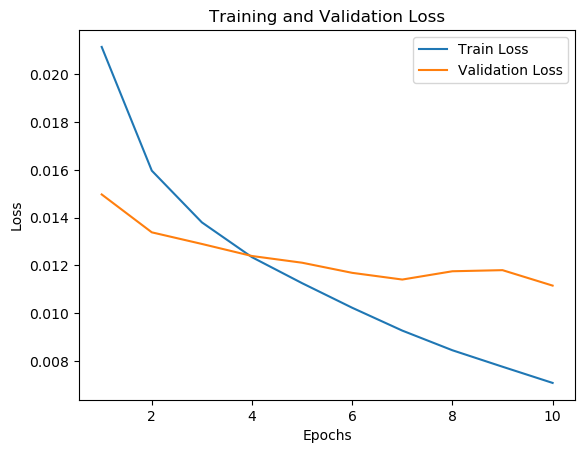

In [11]:
# Plotting Loss
plt.plot(range(1, 11), train_loss, label='Train Loss')
plt.plot(range(1, 11), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [12]:
# Ensure the directory exists
model_save_path = './saved_models/AlexNet_cifar10_RejDiff_finetuned.pth'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
torch.save(AlexNet.state_dict(), model_save_path)
print("Model saved as AlexNet_cifar10_RejDiff_finetuned.pth")

Model saved as AlexNet_cifar10_RejDiff_finetuned.pth


In [13]:
AlexNet.load_state_dict(torch.load(model_save_path, weights_only=True))
AlexNet = AlexNet.to(device)

In [14]:
final_val_loss, final_val_accuracy, final_precision, final_recall, final_f1 = validate(AlexNet, testloader)
print(f'\nFinal Test Results - Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%, Precision: {final_precision:.2f}, Recall: {final_recall:.2f}, F1 Score: {final_f1:.2f}')

100%|███████████████████████████████████████████████████████████| 313/313 [00:15<00:00, 20.11it/s]


Final Test Results - Loss: 0.0112, Accuracy: 87.94%, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
